# MADE: Masked Autoencoder for Distribution Estimation 

## Import modules

In [1]:
from os import path

import numpy as np 
import pandas as pd
from random import shuffle, choices, choice

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

## Load data

In [3]:
mnist = np.load('binarized_mnist.npz')
X_train, X_val = mnist['train_data'], mnist['valid_data']

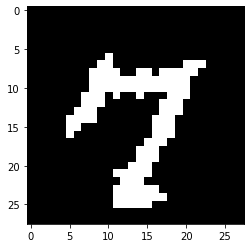

In [4]:
plt.imshow(X_train[4,:].reshape(28,28),cmap='gray')
plt.show()

## Model 

In [5]:
class MaskLinear(keras.layers.Layer):
    """y = w.x + b"""
    def __init__(self,name,units=32, input_dim=32,hidden=False):
        super(MaskLinear, self).__init__()
        self.w = self.add_weight(str(name) + "_weight",
                               shape=[input_dim, units],
                               regularizer=tf.keras.regularizers.l1_l2(.0001))
        self.b = self.add_weight(str(name) + "_bias",
                               shape=[units],
                               regularizer=tf.keras.regularizers.l1_l2(.0001))

        self.hidden = hidden
        if self.hidden == True:
            self.u = self.add_weight(str(name) + "_u_weight",
                shape=[input_dim, units],
                regularizer=tf.keras.regularizers.l1_l2(.0001))
            self.id_vect = tf.ones(input_dim)

    def call(self, inputs,mask):
        if self.hidden == True:
            return tf.matmul(inputs, tf.math.multiply(self.w,mask)) + self.b + tf.tensordot(self.id_vect,tf.math.multiply(self.u,mask), 1)
        else:
            return tf.matmul(inputs, tf.math.multiply(self.w,mask)) + self.b

In [6]:
class MADE(Model):
    def __init__(self,n_mask,input_dim,hidden_dim,hid_layers):
        super(MADE, self).__init__()
        
        self.n_mask = n_mask
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.hid_layers = hid_layers
        
        # Make list of ids for each layer
        print('Starting to make mask')
        self.masks_ids = self.makeMasksIds()
        self.masks = []
        for m_id in self.masks_ids:
            self.masks.append(self.makeMasks(m_id))
        print('Finshed making mask')
        
        # Declare model layers
        self.model_layers = []
        layer = MaskLinear(0,self.hidden_dim,self.input_dim,hidden=True)
        self.model_layers.append(layer)
        for i in range(self.hid_layers):
            layer = MaskLinear(i+1,self.hidden_dim,self.hidden_dim,hidden=True)
            self.model_layers.append(layer)
        layer = MaskLinear(self.hid_layers+2,self.input_dim,self.hidden_dim)
        self.model_layers.append(layer)
                
        # Declare loss tracker 
        self.loss_tracker = keras.metrics.Mean(name="loss")
        
    @property
    def metrics(self):
        """List of the model's metrics.
        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]
    
    def makeMasksIds(self):
        masks_ids = []
        for i in range(self.n_mask):
            ids = list(range(1,self.input_dim+1))
            shuffle(ids)
            dict_mask = {'ids':ids}
            for j in range(1,self.hid_layers+2):
                h_ids = [1] + choices(list(range(1, self.input_dim)), k=self.hidden_dim-1)
                dict_mask["W"+str(j)] = h_ids
            masks_ids.append(dict_mask)
        return masks_ids
    
    def maskLogic(self,input_ids,output_ids,hidden=True):
        masks = np.ones((len(input_ids),len(output_ids)))
        if hidden == True:
            return np.abs(np.less(np.array(output_ids),\
                        np.array(input_ids)[:,np.newaxis]).astype(int)-1)
        else:
            return np.abs(np.greater(np.array(output_ids),\
                        np.array(input_ids)[:,np.newaxis]).astype(int)) 

    def makeMasks(self,masks_ids):
        masks = []

        # Make input mask
        input_m = self.maskLogic(masks_ids['ids'],masks_ids['W1'])
        masks.append(input_m)
        # Make hidden masks 
        for i in range(1,self.hid_layers+1):
            hidden_m = self.maskLogic(masks_ids['W'+str(i)],masks_ids['W'+str(i+1)])
            masks.append(hidden_m)
        # Make output mask
        output_m = self.maskLogic(masks_ids['W'+str(self.hid_layers)],masks_ids['ids'],hidden=False)
        masks.append(output_m)

        return masks
    
    def call(self,X,masks=None):
        if masks == None:
            masks = choice(self.masks)
        
        for i in range(len(self.model_layers)):
            X = self.model_layers[i](X,masks[i])
            if i < len(self.model_layers)-1:
                X = tf.nn.relu(X)
        return X

    def prob(self,X):
        predictions = []
        for m in self.masks:
            yh = self(X,m)
            yh = tf.math.sigmoid(yh)
            yh = tf.math.reduce_mean(X*tf.math.log(yh)+(1-X)*tf.math.log(1-yh), axis=1)
            yh = tf.math.exp(yh)
            predictions.append(yh)
        probs =  tf.math.reduce_mean(predictions,axis=0)
        return probs 

    def train_step(self, data):
        X, y = data
        m_id = choice(range(len(self.masks)))
        mask = self.masks[m_id]
        
        with tf.GradientTape() as tape:
            X = self(X,mask)
            y = tf.math.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(y,X),axis=1)
            loss = tf.math.reduce_mean(y)
            
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        # Return a dict mapping metric names to current value   
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    
    def test_step(self, data):
        X, y = data
        predictions = []
        for m in self.masks:
            yh = self(X,m)
            loss = tf.math.reduce_mean(tf.math.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(X,yh),axis=1))
            predictions.append(loss)
        loss =  tf.math.reduce_mean(predictions)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [7]:
n_mask = 8
input_dim = 784
hidden_dim = 500
hid_layers = 1

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model = MADE(n_mask,input_dim,hidden_dim,hid_layers)
#model.compile(optimizer=opt)
model.compile(optimizer=opt,run_eagerly=True)

Starting to make mask
Finshed making mask


## Fit model 

In [8]:
history = model.fit(X_train, X_train, epochs=25, batch_size=100,validation_data=(X_val, X_val))

Epoch 1/25
500/500 [==============================] - 45s 90ms/step - loss: 210.1022 - val_loss: 171.4082
Epoch 2/25
500/500 [==============================] - 43s 87ms/step - loss: 159.5924 - val_loss: 143.6367
Epoch 3/25
500/500 [==============================] - 43s 85ms/step - loss: 139.2717 - val_loss: 132.2524
Epoch 4/25
500/500 [==============================] - 43s 86ms/step - loss: 129.2717 - val_loss: 122.5943
Epoch 5/25
500/500 [==============================] - 44s 88ms/step - loss: 121.9169 - val_loss: 120.4038
Epoch 6/25
500/500 [==============================] - 44s 88ms/step - loss: 115.1231 - val_loss: 113.9991
Epoch 7/25
500/500 [==============================] - 43s 87ms/step - loss: 111.8451 - val_loss: 115.4792
Epoch 8/25
500/500 [==============================] - 44s 87ms/step - loss: 109.5304 - val_loss: 107.3285
Epoch 9/25
500/500 [==============================] - 44s 87ms/step - loss: 105.7610 - val_loss: 101.2263
Epoch 10/25
500/500 [=========================

Text(0.5, 0, 'epoch')

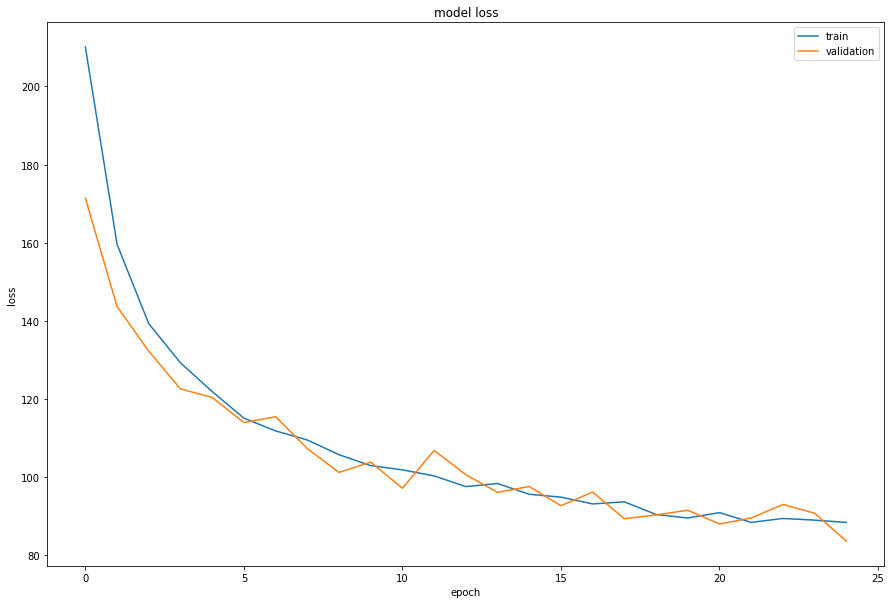

In [9]:
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.legend(["train", "validation"], loc="upper right")
plt.ylabel("loss")
plt.xlabel("epoch")

In [10]:
probs = model.prob(X_val)
print(probs)

tf.Tensor([0.8828966  0.92842627 0.87001306 ... 0.8802528  0.9307288  0.87794685], shape=(10000,), dtype=float32)
